In [2]:
import json
import pandas as pd
import seaborn as sns
import os
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path

from IPython.display import display


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.multicomp import MultiComparison

from const import MASK_TOKEN

pd.options.display.float_format = '{:.4f}'.format

In [3]:
BATCH_SIZE = 64
DEVICE = 'cuda'
LR = 1e-5
NUM_ITER = 30

out_dir_base = Path('data/exp_access/reliance_model')

In [4]:
import load_exp_results
import importlib
importlib.reload(load_exp_results)
valid_user, task_result, f_score, questionnaire, open_question_answer = load_exp_results.load()

In [5]:
# DEMOGRAPHICS

_user, _instruction_quiz_answer, _main_task_result, _questionnaire, _open_question_answer = load_exp_results._load_json()

_user = _user[_user.index.isin(f_score.index)]
_target = _user[_user['python_class'].isin(['RandomCueUser_Threshold', 'RandomCueUser_Proportional'])]
# Reliance dataset
print('age', _target['age'].mean(), _target['age'].std(), _target['age'].min(), _target['age'].max())
print(_target.groupby('sex').count())
print(f_score.groupby('condition').count())

# Evaluation
_target = _user[_user['python_class'].isin(['SelectiveCueUser3'])]
print('age', _target['age'].mean(), _target['age'].std(), _target['age'].min(), _target['age'].max())
print(_target.groupby('sex').count())

age 48.358620689655176 13.117352725635445 19 81
     crowd_id  register_time  submit_password  age  got_consent  \
sex                                                               
1          46             46               46   46           46   
2          98             98               98   98           98   
3           1              1                1    1            1   

     is_no_more_login  task_mode  python_class  
sex                                             
1                  46         46            46  
2                  98         98            98  
3                   1          1             1  
                            f_score  accuracy  rate  reliance
condition                                                    
RandomCueUser_Proportional       50        50    50        50
RandomCueUser_Threshold          95        95    95        95
SelectiveCueUser                 50        50    50        50
SelectiveCueUser2                52        52    52        52

/tmp/ipykernel_1706447/3276330542.py:10: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.swarmplot(data=_target, x='rate', y='f_score', hue='condition', hue_order=['RandomCueUser_Threshold','RandomCueUser_Proportional',], ax=ax, palette=sns.color_palette())


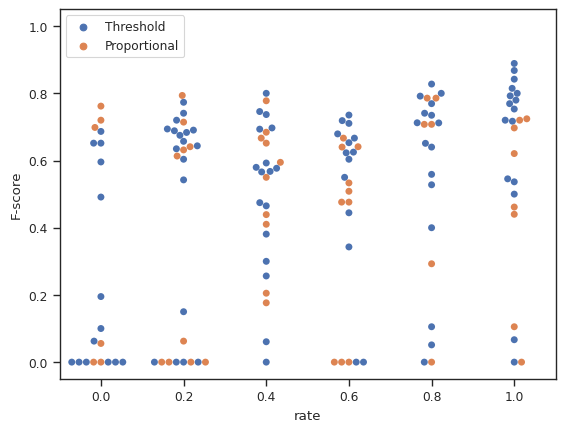

                        df       F  PR(>F)  eta_partial
C(condition)        1.0000  1.6467  0.2015       0.0115
rate                1.0000 12.8807  0.0005       0.0837
rate:C(condition)   1.0000  1.3755  0.2428       0.0097
Residual          141.0000     NaN     NaN       0.5000


<Figure size 640x480 with 0 Axes>

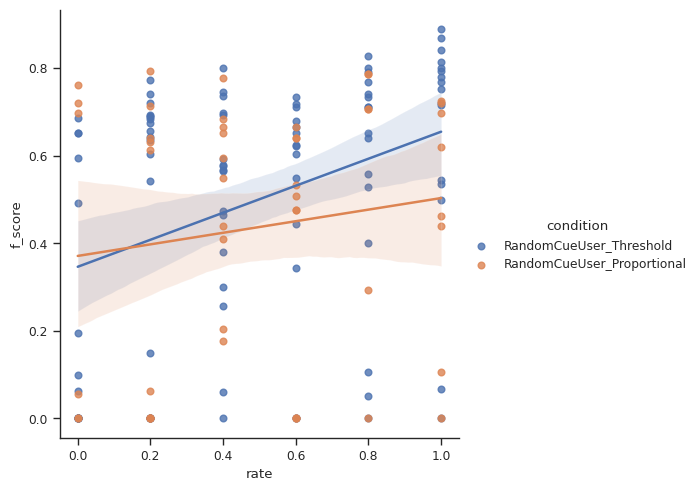

[{'value': 'ロボットの事をあまり考えずに答えてしまった'},
 {'value': 'ロボットのメッセージの表示が遅く感じた'},
 {'value': 'ロボットに任せるような、難しい内容ではなかった'},
 {'value': '認識が難しいものがあればロボットを使用するつもりでいたが、60問すべて比較的簡単に認識できたので、ロボットに任せる必要性を特に感じない問題でした。'},
 {'value': 'ロボットに任せたのは1回だけ。その回答があまりにかけ離れていたのでそれ以降は自分で回答した。また、自分で判読するに十分な「見えにくさ」だったと思う。\r\n実験の役に立てたのか疑問。'},
 {'value': '最初の数問、判読しにくい設問の時に、試しにロボットに入力させてみたら、全く的外れな回答だった。２回試してみてロボットは当てにならないと判断し、あとは全て人力で回答した。'},
 {'value': 'はじめはロボットはわざと間違った答えを出していると思った。\r\n当てにならないと後半思った'},
 {'value': '読みづらいと感じた時には役に立つ'},
 {'value': '一度読めるかを確認後入力の選択を実施したのでロボットに任せたのは2件だけだった。\u3000読み辛かった2件ともロボットは不正解だったような気がするので画像認識は得意ではないと判断した。'},
 {'value': ''},
 {'value': 'ロボットに任せるような、難しい内容ではなかった'},
 {'value': '大文字、小文字の使い分けが不要なので、自分での入力が簡単にできました。そのうえで、判読が難しいものはロボットに任せたところ、出来が悪く思えたので、以後は自分の入力に努めました。'},
 {'value': '最初の不明瞭な文字をロボットに任せましたが、明らかにおかしな判定だったので、その後は自分で判断しました。'},
 {'value': 'ロボットの回答はあまり信頼できなかった'},
 {'value': 'ロボットの回答が全然信用できなかったので自力で回答したほうが断然よかった。最初にロボットが間違えると使いたくなる'},
 {'value': '今回は検査の意図をあまり理解しておらず、全て自身で入力してしまいました'},
 {'va

In [6]:
# Figure 5

sns.set()
sns.set_theme(style="ticks")
sns.set_context("paper")

_target = f_score[(f_score['condition'] == 'RandomCueUser_Threshold') +  (f_score['condition'] == 'RandomCueUser_Proportional')]
fig, ax = plt.subplots()

sns.swarmplot(data=_target, x='rate', y='f_score', hue='condition', hue_order=['RandomCueUser_Threshold','RandomCueUser_Proportional',], ax=ax, palette=sns.color_palette())

ax.set_ylabel('F-score')
ax.set_ylim([-0.05, 1.05])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Threshold', 'Proportional'], loc='upper left')

plt.savefig('dataset.pdf', bbox_inches='tight')
plt.show()


formula = 'f_score ~ rate * C(condition)'
model = ols(formula, _target).fit()
aov_table = anova_lm(model, typ=2)
aov_table['eta_partial'] = aov_table['sum_sq'] / (aov_table['sum_sq'] + aov_table.loc['Residual', 'sum_sq'])
aov_table = aov_table.drop('sum_sq', axis=1)
print(aov_table)


plt.clf()
sns.lmplot(data=_target, x='rate', y='f_score', hue='condition')
plt.show()


_open_question_answer[_open_question_answer['user_id'].isin(
    _target.query('rate<=0.2 and reliance < 0.1').index
)]['answers'].tolist()


In [7]:
# Out-of-range data
_target = f_score[ (f_score['condition'] == 'SelectiveCueUser3')]
print(_target.query('rate <= 0.2').count(), _target.query('rate > 0.8').count())

f_score      18
accuracy     18
condition    18
rate         18
reliance     18
dtype: int64 f_score      13
accuracy     13
condition    13
rate         13
reliance     13
dtype: int64


condition
RandomCueUser_Threshold    47
SelectiveCueUser3          67
dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/regression.py:582: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


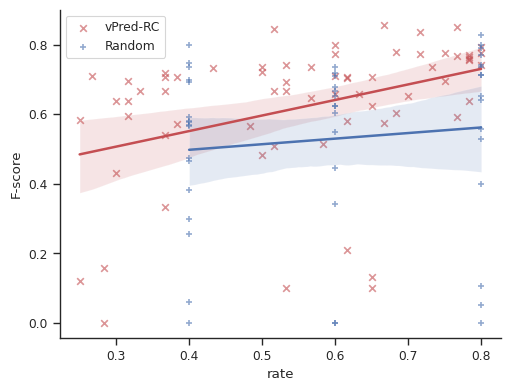

f_score ~ rate * C(condition)


,sum_sq,df,F,PR(>F),eta_partial
C(condition),0.3040,1.0000,6.5748,0.0117,0.0564
rate,0.3528,1.0000,7.6293,0.0067,0.0649
rate:C(condition),0.0641,1.0000,1.3866,0.2415,0.0124
Residual,5.0867,110.0000,NaN,NaN,0.5000


In [8]:
# Figure 7
_target = f_score[(f_score['condition'] == 'RandomCueUser_Threshold') +  (f_score['condition'] == 'SelectiveCueUser3')]

_target = _target[(_target['rate'] > 0.2) * (_target['rate'] <= 0.8)]
print(_target.groupby('condition').apply(len))
palette=list(sns.color_palette())[3::-3]
g = sns.lmplot(data=_target, x='rate', y='f_score', hue='condition', hue_order=['SelectiveCueUser3','RandomCueUser_Threshold', ], markers=['x', '+'], scatter_kws={'alpha':0.6},
                x_ci='ci', palette=palette, legend_out=False, height=4, aspect=1.3)
g.set_ylabels('F-score')
g._legend.set_title(None)
new_labels = ['vPred-RC', 'Random',]
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
plt.savefig("f_score.pdf", bbox_inches='tight')
plt.show(g)


formula = 'f_score ~ rate * C(condition)'
model = ols(formula, _target).fit()
aov_table = anova_lm(model, typ=2)
aov_table['eta_partial'] = aov_table['sum_sq'] / (aov_table['sum_sq'] + aov_table.loc['Residual', 'sum_sq'])
print(formula)
display(aov_table)
 


\subfigure[Instruction 1]{
\begin{tabular}{r|p{1.5em}|p{3.3em}|p{3.3em}|p{3.3em}}
& df & F & PR(>F) & $\eta_p^2$ \\ \hline 
condition & 1.0000 & 0.0009 & 0.9761 & 0.0000\\ 
rate & 1.0000 & 0.9486 & 0.3322 & 0.0086\\ 
rate:condition & 1.0000 & 0.0031 & 0.9559 & 0.0000\\ 
Residual & 110.0000 & nan & nan & 0.5000\\ 

\end{tabular}
}

\subfigure[Instruction 2]{
\begin{tabular}{r|p{1.5em}|p{3.3em}|p{3.3em}|p{3.3em}}
& df & F & PR(>F) & $\eta_p^2$ \\ \hline 
condition & 1.0000 & 0.0005 & 0.9827 & 0.0000\\ 
rate & 1.0000 & 0.5008 & 0.4807 & 0.0045\\ 
rate:condition & 1.0000 & 1.0116 & 0.3167 & 0.0091\\ 
Residual & 110.0000 & nan & nan & 0.5000\\ 

\end{tabular}
}

\subfigure[Performance understanding]{
\begin{tabular}{r|p{1.5em}|p{3.3em}|p{3.3em}|p{3.3em}}
& df & F & PR(>F) & $\eta_p^2$ \\ \hline 
condition & 1.0000 & 1.4315 & 0.2341 & 0.0128\\ 
rate & 1.0000 & 0.0000 & 0.9944 & 0.0000\\ 
rate:condition & 1.0000 & 0.1279 & 0.7213 & 0.0012\\ 
Residual & 110.0000 & nan & nan & 0.5000\\ 

\end{t

/root/.local/share/virtualenvs/kabu_summarizer-Xgg0Bd0D/lib/python3.8/site-packages/seaborn/regression.py:582: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


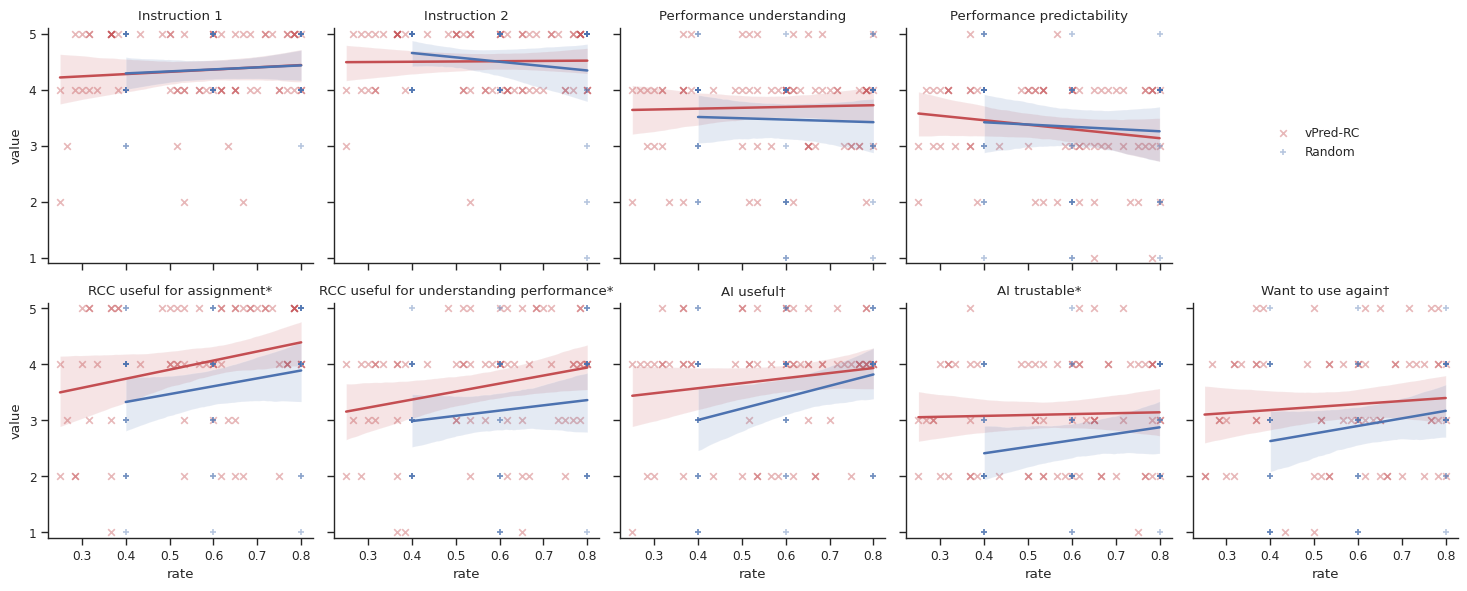

In [42]:
import re
pd.options.display.float_format = '{:.4f}'.format

q_labels = ['instruction1', 'instruction2', 'understandable', 'predictable', 'instance_conf_decision', 'instance_conf_understand', 'useful', 'trust', 'future']
q_labels_new = ['Instruction 1', 'Instruction 2', 'Performance understanding', 'Performance predictability', 'RCC useful for assignment*', 'RCC useful for understanding performance*', 'AI useful†', 'AI trustable*', 'Want to use again†']
q_label_dict = {l: l_new for (l, l_new) in zip(q_labels, q_labels_new)}

questionnaire['condition'] = questionnaire.index.map(lambda uid: f_score.loc[uid, 'condition'])
questionnaire['rate'] = questionnaire.index.map(lambda uid: f_score.loc[uid, 'rate'])
questionnaire_target = questionnaire[(questionnaire['condition'] == 'RandomCueUser_Threshold') + (questionnaire['condition'] == 'SelectiveCueUser3')]
questionnaire_target = questionnaire_target[(0.2 < questionnaire_target['rate']) * (0.8 >= questionnaire_target['rate'])]

def to_latex(anova_table):
    def _float_to_str(val):
        return "{:.4f}".format(val)
    columns = anova_table.columns
    index = aov_table.index
    index = map(lambda s: re.sub('C\((.+)\)', r'\1', s), index)
    values = anova_table.values.tolist()

    ret = '& ' + ' & '.join(columns) + ' \\\\ \\hline \n'
    for index, line in zip(index, values):
        ret += f'{index} & ' + ' & '.join(map(_float_to_str, line)) + '\\\\ \n'
    return ret
    
for column in ['instruction1', 'instruction2', 'understandable', 'predictable', 'instance_conf_decision', 'instance_conf_understand', 'useful', 'trust', 'future']:
    if column in ['condition', 'rate']:
        continue
    _data = questionnaire_target[[column, 'condition', 'rate']]
    label = q_label_dict[column]
    print(f'\\subfigure[{label}]' + '{')
    print(r'\begin{tabular}{r|p{1.5em}|p{3.3em}|p{3.3em}|p{3.3em}}')  
    formula = f'{column} ~ rate * C(condition)'
    model = ols(formula, _data).fit()
    aov_table = anova_lm(model, typ=2)
    aov_table['$\\eta_p^2$'] = aov_table['sum_sq'] / (aov_table['sum_sq'] + aov_table.loc['Residual', 'sum_sq'])
    aov_table = aov_table.drop('sum_sq', axis=1)
    print(to_latex(aov_table))
    print(r'\end{tabular}')
    print('}\n')

_target = questionnaire_target.reset_index().set_index(['user_id', 'rate', 'condition']).stack().reset_index().rename(columns={'item_name': 'question', 0: 'value'})
_target = _target.query('value != 4.5')



row = {label: r for (label, r) in zip(q_labels, [0,0,0,0,1,1,1,1,1])}
column = {label: c for (label, c) in zip(q_labels, [0,1,2,3,0,1,2,3,4])}
coordinates_rev = {(row[label], column[label]): label for label in q_labels}
_target['row'] = _target['question'].map(row)
_target['column'] = _target['question'].map(column)

g = sns.lmplot(data=_target, col='column', row='row',
               x='rate', y='value', hue='condition', hue_order=['SelectiveCueUser3','RandomCueUser_Threshold', ], 
               legend_out=True, palette=list(sns.color_palette())[3::-3], markers=['x', '+'], scatter_kws={'alpha':0.4},
               height=3, )
new_labels = ['vPred-RC', 'Random',]
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
g._legend.set_title(None)
sns.move_legend(g, "upper left", bbox_to_anchor=(.75, .8))

for r, axes in enumerate(g.axes):
    for c, ax in enumerate(axes):
        ax.set_ylim([0.9, 5.1])
        ax.set_yticks(range(1,6))
        
        if (r,c) in coordinates_rev.keys():
            ax.set_title(q_label_dict[coordinates_rev[(r, c)]])
        else:
            ax.set_visible(False)


plt.savefig('questionnaire.pdf', bbox_inches='tight')



In [16]:
import torch
import numpy as np

import inference
inference.init()

def which_dtype(array):
    if type(array) == torch.Tensor:
        return array.dtype
    if np.issubdtype(array.dtype, np.integer):
        return torch.long
    elif np.issubdtype(array.dtype, np.floating):
        return torch.float32
    elif np.issubdtype(array.dtype, np.bool_):
        return torch.bool

def get_input(user_id, target_index):
    example = task_result[task_result['user_id'] == user_id].sort_values('episode_id')

    src = dict()
    src['middles'] = np.vstack(example.apply(lambda raw: inference.get_y(raw['dataset_name'], 'captcha-09az+capital-color', raw['ground_truth'], ['middle'])[0], axis=1).values).astype(np.float32)
    src['cues'] = example['system_action_token'].values.copy()
    src['decisions'] = example['user_decision_token'].values.copy()

    src = {key: torch.tensor(value, dtype=which_dtype(value)) for key, value in src.items()}
    mask = {'middles': torch.zeros((src['middles'].shape[0]), dtype=torch.bool)}

    mask['middles'][target_index+1:] = True

    ys = example.apply(lambda raw: inference.get_y(raw['dataset_name'], 'captcha-09az+capital-color', raw['ground_truth'], ['y'])[0], axis=1).values[target_index]
    return src, mask, ys

class Dataset(torch.utils.data.Dataset):
    def __init__(self, user_ids, rtn_acc=False):
        self.user_ids = user_ids
        self.n_episode = 60
        self.rtn_acc = rtn_acc
        return

    def __len__(self):
        return self.n_episode * len(self.user_ids)

    def __getitem__(self, idx):
        user_id = self.user_ids[idx // self.n_episode]
        episode_idx = idx % self.n_episode
        src, mask, ys = get_input(user_id, episode_idx)
        length = src['middles'].shape[0]

        src = {key: self._padding(value, self.n_episode, 0) for key, value in src.items()}
        mask = {key: self._padding(value, self.n_episode, True) for key, value in mask.items()}

        if length <= episode_idx:
            # ignore_index
            label = [torch.tensor(-100)]
        else:
            # 0: AI, 1: SELF
            label = src['decisions'][episode_idx].clone() - 1
        # add [MASK] token
        src['decisions'][episode_idx:] = MASK_TOKEN

        if self.rtn_acc:
            conf = inference.instance_confidence_calculators['captcha-09az+capital-color'].calc_score(
                ys.reshape((1, 36, 5))
            )
            acc = inference.acc_estimators['captcha-09az+capital-color'].predict_proba(conf.reshape((1, 1)))[0,1]
            return (src, mask, idx % self.n_episode), label, acc
        return (src, mask, idx % self.n_episode), label

    def _padding(self, array, length, value=None):
        orig_length = array.shape[0]
        if orig_length == length:
            return array
        elif orig_length > length:
            raise ValueError('Input array too long.')
        addition = torch.concat([torch.empty_like(array[:1])] * (length - array.shape[0]))
        if value is not None:
            addition[:] = value
        return torch.concat([array, addition])

import trust_model
models = list()
for model_dir in out_dir_base.glob('[0-9]'):
    model = trust_model.SimpleTransformerEncoder_Access(n_head=16, n_feature=128, dropout=0.2, n_hidden=2048, n_layers=3, n_out=2)
    model.load_state_dict(torch.load(model_dir / '19.pth'))
    model.eval()
    model = model.to(DEVICE)
    models.append(model)


# hist of threshold (all)
ids = pd.DataFrame(sum(
[[{'name': f'{line["condition"]}-{line["rate"]}', 'index': item} for item in line[0]] 
    for _, line in pd.DataFrame(f_score.groupby(['condition', 'rate']).apply(lambda grp: grp.index)).reset_index().iterrows()],
    list())).set_index('index')
dataset = Dataset(ids.index, rtn_acc=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)
diff_distribution = list()
for (src, mask, target_idx), label, acc in dataloader:
    #print(src['middles'].permute((1,0,2)).shape, src['cues'].permute((1,0)).shape)
    src['middles'] = src['middles'].permute((1,0,2)).tile((1, 3, 1))
    src['cues'] = src['cues'].permute((1,0)).tile((1, 3))
    src['decisions'] = src['decisions'].permute((1,0)).tile((1, 3))
    src['middles_mask'] = mask['middles'].tile(3, 1)
    del mask
    src['cues'][target_idx] = torch.tensor([1,2,3], dtype=torch.long)
    for key, value in src.items():
        src[key] = value.to(DEVICE)
    p_current = torch.stack([model(**src)[target_idx[0]].softmax(1) for model in models]).mean(dim=0)[:, 0]
    diff = (p_current - acc.item()).abs()
    diff_distribution.append((diff[2] - diff[:2].min()).item())
diff_distribution = np.array(diff_distribution)
sns.histplot(diff_distribution)
np.save('diff_distribution.npy', diff_distribution)



diff_distribution = np.load('diff_distribution.npy')
sns.histplot(diff_distribution)
plt.savefig('diff_distribution.pdf')

n = diff_distribution.shape[0]
diff_distribution.sort()
[diff_distribution[int(n * r)] for r in np.arange(0.2, 1, 0.2)][::-1]

[0.23420780897140503,
 0.14439991116523743,
 0.08581850677728653,
 0.049771592020988464,
 0.026333104819059372]

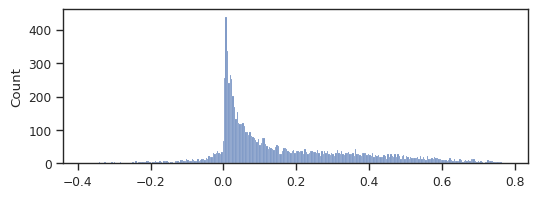

In [19]:
# Figure 6
dataset = Dataset(f_score[(f_score['condition'] == 'RandomCueUser_Threshold') + (f_score['condition'] == 'RandomCueUser_Proportional')].index, rtn_acc=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)
diff_distribution = list()
for (src, mask, target_idx), label, acc in dataloader:
    src['middles'] = src['middles'].permute((1,0,2)).tile((1, 3, 1))
    src['cues'] = src['cues'].permute((1,0)).tile((1, 3))
    src['decisions'] = src['decisions'].permute((1,0)).tile((1, 3))
    src['middles_mask'] = mask['middles'].tile(3, 1)
    del mask
    src['cues'][target_idx] = torch.tensor([1,2,3], dtype=torch.long)
    for key, value in src.items():
        src[key] = value.to(DEVICE)
    p_current = torch.stack([model(**src)[target_idx[0]].softmax(1) for model in models]).mean(dim=0)[:, 0]
    diff = (p_current - acc.item()).abs()
    diff_distribution.append((diff[2] - diff[:2].min()).item())
diff_distribution = np.array(diff_distribution)
sns.histplot(diff_distribution)
np.save('diff_distribution_test_random.npy', diff_distribution)

fig, ax = plt.subplots(figsize=(6,2))

diff_distribution = np.load('diff_distribution_test_random.npy')
sns.histplot(diff_distribution, color=sns.color_palette()[0], bins=300)
plt.savefig('diff_distribution_test_random.pdf', bbox_inches='tight')


n = diff_distribution.shape[0]
diff_distribution.sort()
[diff_distribution[int(n * r)] for r in np.arange(0.3, 0.8, 0.1)][::-1]

In [45]:
_target = open_question_answer[open_question_answer['user_id'].isin(
                     f_score[(f_score['condition'] == 'SelectiveCueUser3') * (f_score['rate'] > 0.2) * (f_score['rate'] <= 0.8)].index
)]
_target['rate'] = _target['user_id'].map(lambda user_id: f_score.loc[user_id, 'rate'])
_target['f_score'] = _target['user_id'].map(lambda user_id: f_score.loc[user_id, 'f_score'])
_target = _target.drop(columns=['register_time', 'task_name', 'item_name'])
import csv

with open('open_question_answer.csv', 'w', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(_target.columns.values.tolist())
    for line in _target.values.tolist():
        writer.writerow(line)


/tmp/ipykernel_2828062/53022933.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _target['rate'] = _target['user_id'].map(lambda user_id: f_score.loc[user_id, 'rate'])
/tmp/ipykernel_2828062/53022933.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _target['f_score'] = _target['user_id'].map(lambda user_id: f_score.loc[user_id, 'f_score'])


In [49]:
_target = open_question_answer[open_question_answer['user_id'].isin(
                     f_score[(f_score['condition'] == 'RandomCueUser_Threshold') * (f_score['rate'] > 0.2) * (f_score['rate'] <= 0.8)].index
)]
_target['rate'] = _target['user_id'].map(lambda user_id: f_score.loc[user_id, 'rate'])
_target['f_score'] = _target['user_id'].map(lambda user_id: f_score.loc[user_id, 'f_score'])
_target = _target.drop(columns=['register_time', 'task_name', 'item_name'])
import csv

with open('open_question_answer.csv', 'w', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(_target.columns.values.tolist())
    for line in _target.values.tolist():
        writer.writerow(line)

/tmp/ipykernel_2828062/3618408028.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _target['rate'] = _target['user_id'].map(lambda user_id: f_score.loc[user_id, 'rate'])
/tmp/ipykernel_2828062/3618408028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _target['f_score'] = _target['user_id'].map(lambda user_id: f_score.loc[user_id, 'f_score'])


/tmp/ipykernel_3147771/4212318241.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _target['target_rate'] = cue_rates[_target.index % 5]


PearsonRResult(statistic=0.6786678051223041, pvalue=1.6035473994896456e-14)

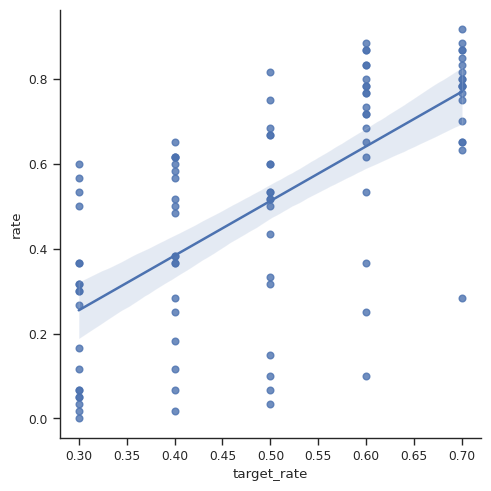

In [17]:
# Correlation between threshold and rate
import numpy as np
cue_rates = np.arange(0.3, 0.8, 0.1)
_target = f_score[ (f_score['condition'] == 'SelectiveCueUser3')]

_target['target_rate'] = cue_rates[_target.index % 5]

sns.lmplot(data=_target, x='target_rate', y='rate')
from scipy.stats import pearsonr
pearsonr(_target['target_rate'], _target['rate'])

In [21]:
pd.set_option('display.max_rows', 100)
#display(task_result)
task_result['assignment_correct'] = task_result['ai_correct']== (task_result['user_decision'] == 'AI')
performance = task_result[task_result['user_class'] == 'SelectiveCueUser3'].query("episode_id < 6").sort_values('episode_id').groupby('user_id').mean()
display(performance.query('assignment_correct >= 5.0/6'))
display(performance.query('assignment_correct <= 1.0/6'))

/tmp/ipykernel_3147771/2237917444.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  performance = task_result[task_result['user_class'] == 'SelectiveCueUser3'].query("episode_id < 6").sort_values('episode_id').groupby('user_id').mean()


,episode_id,ai_correct,final_answer_correct,cue_shown,system_action_token,user_decision_token,assignment_correct
user_id,,,,,,,
409,2.5000,0.5000,0.8333,0.8333,1.5000,1.6667,0.8333
413,2.5000,0.1667,0.8333,1.0000,1.1667,1.6667,0.8333
423,2.5000,0.5000,0.8333,1.0000,1.3333,1.6667,0.8333
424,2.5000,0.3333,0.8333,0.8333,1.5000,1.8333,0.8333
427,2.5000,0.8333,1.0000,0.5000,2.3333,1.1667,1.0000
441,2.5000,0.5000,1.0000,0.5000,2.3333,1.6667,0.8333
444,2.5000,0.3333,0.8333,0.6667,1.6667,1.5000,0.8333
464,2.5000,0.3333,0.6667,0.8333,1.5000,1.8333,0.8333
468,2.5000,0.1667,0.8333,1.0000,1.1667,1.6667,0.8333


,episode_id,ai_correct,final_answer_correct,cue_shown,system_action_token,user_decision_token,assignment_correct
user_id,,,,,,,
445,2.5000,0.6667,0.5000,0.1667,2.8333,1.8333,0.1667
463,2.5000,0.8333,1.0000,0.3333,2.6667,2.0000,0.1667
498,2.5000,0.6667,0.8333,0.8333,1.8333,1.8333,0.1667
546,2.5000,0.8333,0.8333,0.5000,2.5000,1.8333,0.0000
565,2.5000,0.8333,0.8333,0.5000,2.3333,1.6667,0.1667


In [54]:
# Figure 8 (a) (successful example)
_target = task_result[task_result['user_class'] == 'SelectiveCueUser3']
columns = ['user_id', 'episode_id', 'dataset_name', 'ground_truth', 'ai_answer',
       'potential_cue', 'user_decision', 'system_action',
       'final_answer', 'user_class', 'ai_correct', 'final_answer_correct', 'cue_shown',
       'assignment_correct']
display(_target.query("episode_id < 6").sort_values('episode_id').query('user_id == 545')[columns])


,user_id,episode_id,dataset_name,ground_truth,ai_answer,potential_cue,user_decision,system_action,final_answer,user_class,ai_correct,final_answer_correct,cue_shown,assignment_correct
id,,,,,,,,,,,,,,
24512,545,0,captcha-images,rhzrx,e7c2x,unconfident,SELF,neutral,rhzrx,SelectiveCueUser3,False,True,False,True
24527,545,1,capital-color,khcys,khcys,confident,AI,confident,khcys,SelectiveCueUser3,True,True,True,True
24554,545,2,captcha-images,qngsz,xmme2,unconfident,SELF,neutral,qngsz,SelectiveCueUser3,False,True,False,True
24564,545,3,captcha-09az,wbncw,wbccw,confident,SELF,neutral,wbncw,SelectiveCueUser3,False,True,False,True
24574,545,4,capital-color,wfe4c,wfe4c,confident,AI,confident,wfe4c,SelectiveCueUser3,True,True,True,True
24579,545,5,captcha-images,rbiol,f7fx2,unconfident,AI,neutral,f7fx2,SelectiveCueUser3,False,False,False,False


In [23]:
# Figure 8 (b) (unsuccessful example)
display(_target.query("episode_id < 20").sort_values('episode_id').query('user_id == 565')[columns])

,user_id,episode_id,dataset_name,ground_truth,ai_answer,potential_cue,user_decision,system_action,final_answer,user_class,ai_correct,final_answer_correct,cue_shown,assignment_correct
id,,,,,,,,,,,,,,
25655,565,0,captcha-09az,fg38b,fg38b,confident,AI,neutral,fg38b,SelectiveCueUser3,True,True,False,True
25677,565,1,capital-color,nrby8,nrby8,confident,SELF,neutral,nrby8,SelectiveCueUser3,True,True,False,False
25706,565,2,capital-color,s3ych,s3ych,unconfident,SELF,unconfident,s3ych,SelectiveCueUser3,True,True,True,False
25714,565,3,captcha-09az,5bnd7,56nd7,confident,AI,confident,56nd7,SelectiveCueUser3,False,False,True,False
25725,565,4,capital-color,lmxbd,lmxbd,confident,SELF,neutral,lmxbd,SelectiveCueUser3,True,True,False,False
25737,565,5,capital-color,ppfuk,ppfuk,confident,SELF,confident,ppfuk,SelectiveCueUser3,True,True,True,False
25749,565,6,capital-color,sybe3,sybe3,confident,SELF,confident,sybe3,SelectiveCueUser3,True,True,True,False
25754,565,7,captcha-images,efcns,f3cx2,unconfident,AI,neutral,f3cx2,SelectiveCueUser3,False,False,False,False
25763,565,8,capital-color,c9mxn,c3mxn,confident,SELF,confident,c9mxn,SelectiveCueUser3,False,True,True,True
